In [4]:
import pickle
import numpy as np

import config

In [6]:
import torch
from torch.utils.data import Dataset

In [126]:
# read deforestation data
deforestation_history = pickle.load(open(config.TR_DEFORESTATION, "rb"))
deforestation_history.shape

(113, 113, 74)

In [127]:
# normalize
deforestation_history = (deforestation_history - 0.5)*2

In [128]:
# reshape to add channel
deforestation_history = H.reshape((1, 113, 113, 74))
deforestation_history.shape

(1, 113, 113, 74)

In [134]:
class CustomDataset(Dataset):
    def __init__(self, X):
        super(CustomDataset, self).__init__()
        
        self.X = X[:, :, :, :-1]
        self.Y = X[:, :, :, 1:]

    def __len__(self):
        return self.X.shape[-1]

    def __getitem__(self, index):
        data = torch.tensor(self.X[:, :, :, index]).float()
        labels = torch.tensor(self.Y[:, :, :, index]).float()
        return data, labels

In [190]:
train_data = deforestation_history[:, :, :, 18:-12]
test_data = deforestation_history[:, :, :, -13:]

In [198]:
train_data.shape, test_data.shape

((1, 113, 113, 44), (1, 113, 113, 13))

In [199]:
trainloader = torch.utils.data.DataLoader(
    CustomDataset(train_data),
    batch_size=1,
    shuffle=False
)

testloader = torch.utils.data.DataLoader(
    CustomDataset(test_data),
    batch_size=1,
    shuffle=False
)

In [200]:
# baseline
train_err = 0
for inputs, labels in trainloader:
    y_pred = inputs
    train_err += torch.square(y_pred - labels).float().mean()
train_err /= len(trainloader)
    
test_err = 0
for inputs, labels in testloader:
    y_pred = inputs
    test_err += torch.square(y_pred - labels).float().mean()
test_err /= len(testloader)

print(f"Baseline: Train Error = {train_err:.6f} | Test Error = {test_err:.6f}")

Baseline: Train Error = 0.000564 | Test Error = 0.001199


In [263]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision

 
class BasicConvModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.epoch = 0
        self.errs = []
        self.conv1 = nn.Conv2d(1, 64, kernel_size=(5,5), stride=1, padding=2)
        self.act1 = nn.ReLU()
 
        self.conv2 = nn.Conv2d(64, 64, kernel_size=(5,5), stride=1, padding=2)
        self.act2 = nn.ReLU()
 
        self.conv3 = nn.Conv2d(64, 1, kernel_size=(5,5), stride=1, padding=2)
 
    def forward(self, x):
        x = self.act1(self.conv1(x))
        x = self.act2(self.conv2(x))
        x = self.conv3(x)
        return x

In [264]:
model = BasicConvModel()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

errs = []

def train(n_epochs):
    for epoch in range(n_epochs):
        model.epoch += 1
        for inputs, labels in trainloader:
            y_pred = model(inputs)
            loss = torch.square(y_pred - labels).mean()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        train_err = 0
        for inputs, labels in trainloader:
            y_pred = model(inputs)
            train_err += torch.square(y_pred - labels).float().mean()
        train_err /= len(trainloader)
            
        test_err = 0
        for inputs, labels in testloader:
            y_pred = model(inputs)
            test_err += torch.square(y_pred - labels).float().mean()
        test_err /= len(testloader)
        model.errs.append([train_err, test_err])

        print(f"Epoch {model.epoch}: Train Error = {train_err:.6f} | Test Error = {test_err:.6f}")

train(10)

Epoch 1: Train Error = 0.034774 | Test Error = 0.039593
Epoch 2: Train Error = 0.010356 | Test Error = 0.012005
Epoch 3: Train Error = 0.005583 | Test Error = 0.006582
Epoch 4: Train Error = 0.004376 | Test Error = 0.005275
Epoch 5: Train Error = 0.003939 | Test Error = 0.004818
Epoch 6: Train Error = 0.003621 | Test Error = 0.004488
Epoch 7: Train Error = 0.003377 | Test Error = 0.004236
Epoch 8: Train Error = 0.003161 | Test Error = 0.004013
Epoch 9: Train Error = 0.002947 | Test Error = 0.003792
Epoch 10: Train Error = 0.002759 | Test Error = 0.003597


In [265]:
train(30)

Epoch 11: Train Error = 0.002617 | Test Error = 0.003450
Epoch 12: Train Error = 0.002513 | Test Error = 0.003343
Epoch 13: Train Error = 0.002431 | Test Error = 0.003260
Epoch 14: Train Error = 0.002363 | Test Error = 0.003190
Epoch 15: Train Error = 0.002303 | Test Error = 0.003129
Epoch 16: Train Error = 0.002249 | Test Error = 0.003073
Epoch 17: Train Error = 0.002200 | Test Error = 0.003023
Epoch 18: Train Error = 0.002156 | Test Error = 0.002977
Epoch 19: Train Error = 0.002115 | Test Error = 0.002935
Epoch 20: Train Error = 0.002077 | Test Error = 0.002896
Epoch 21: Train Error = 0.002042 | Test Error = 0.002861
Epoch 22: Train Error = 0.002010 | Test Error = 0.002827
Epoch 23: Train Error = 0.001980 | Test Error = 0.002797
Epoch 24: Train Error = 0.001953 | Test Error = 0.002769
Epoch 25: Train Error = 0.001928 | Test Error = 0.002743
Epoch 26: Train Error = 0.001905 | Test Error = 0.002720
Epoch 27: Train Error = 0.001884 | Test Error = 0.002698
Epoch 28: Train Error = 0.00186

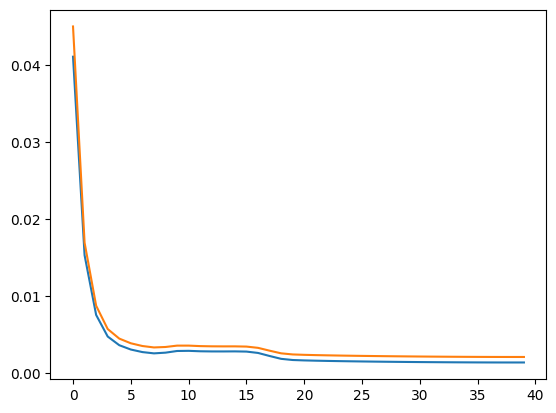

In [256]:
import matplotlib.pyplot as plt

plt.plot([float(e[0]) for e in model.errs])
plt.plot([float(e[1]) for e in model.errs])
plt.show()